### Eye Pattern Recognition

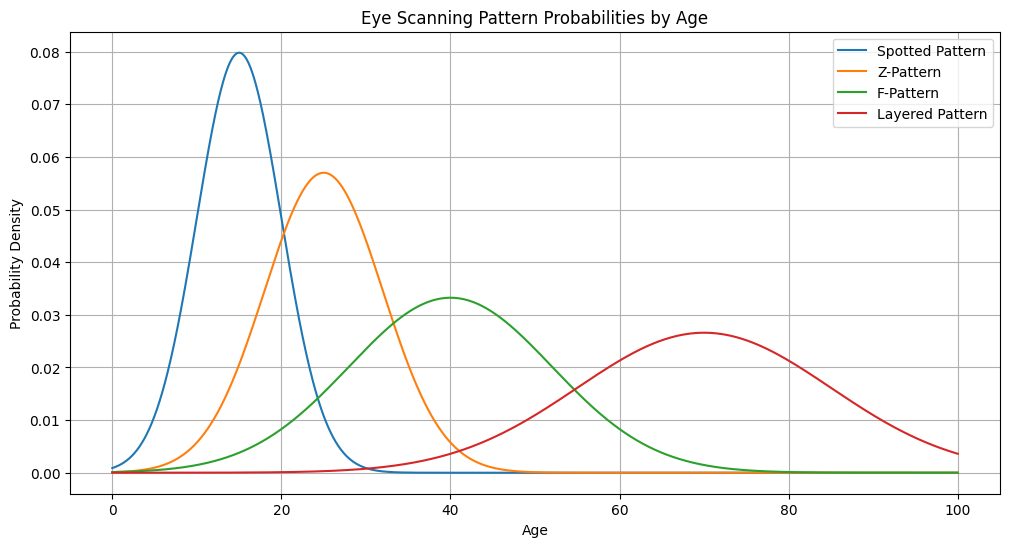


Quick predictions:
Age 15: Spotted Pattern
Age 22: Z-Pattern
Age 35: F-Pattern
Age 65: Layered Pattern
Age 75: Layered Pattern


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

class EyePatternPredictor:
    def __init__(self):
        # Define patterns with their normal distributions (mean, std)
        self.patterns = {
            'spotted': norm(15, 5),   # Teenagers - scattered, non-linear exploration pattern
            'z_pattern': norm(25, 7),  # Young adults - quick zigzag assessment pattern
            'f_pattern': norm(40, 12), # Middle-aged - horizontal top + vertical left scanning
            'layered': norm(70, 15)    # Elderly - methodical, layer-by-layer reading
        }
        
        self.pattern_names = {
            'spotted': 'Spotted Pattern',
            'z_pattern': 'Z-Pattern',
            'f_pattern': 'F-Pattern',
            'layered': 'Layered Pattern'
        }

    def predict(self, age):
        """Predicts single most likely eye scanning pattern for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # small interval (epsilon) around the point
        epsilon = 0.1
        
        probabilities = {
            pattern: dist.cdf(age + epsilon/2) - dist.cdf(age - epsilon/2)
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities to sum to 1
        total = sum(probabilities.values())
        normalized_probs = {
            k: v/total for k, v in probabilities.items()
        }
        
        # Select pattern with highest probability
        selected_pattern = max(normalized_probs, key=normalized_probs.get)
        return self.pattern_names[selected_pattern]

    def explain_prediction(self, age):
        """Shows detailed probability breakdown for given age."""
        if age < 0 or age > 120:
            return "Invalid age input"
        
        # Get raw probabilities
        raw_probs = {
            pattern: dist.pdf(age) 
            for pattern, dist in self.patterns.items()
        }
        
        # Normalize probabilities
        total = sum(raw_probs.values())
        normalized = {k: v/total for k, v in raw_probs.items()}
        
        print(f"\nProbability breakdown for age {age}:")
        print("\nRaw probabilities (from PDF):")
        for pattern, prob in raw_probs.items():
            print(f"{self.pattern_names[pattern]}: {prob:.4f}")
            
        print("\nNormalized probabilities:")
        for pattern, prob in normalized.items():
            print(f"{self.pattern_names[pattern]}: {prob:.2%}")
            
        winner = max(normalized, key=normalized.get)
        print(f"\nPredicted pattern: {self.pattern_names[winner]}")

    def visualize_distributions(self):
        """Visualizes the probability distributions for all patterns."""
        ages = np.linspace(0, 100, 1000)
        
        plt.figure(figsize=(12, 6))
        
        # Plot each distribution
        for pattern, dist in self.patterns.items():
            probabilities = dist.pdf(ages)
            plt.plot(ages, probabilities, label=self.pattern_names[pattern])
        
        # Plot styling
        plt.title('Eye Scanning Pattern Probabilities by Age')
        plt.xlabel('Age')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.show()


# Create predictor
eye_pattern_predictor = EyePatternPredictor()

# Show distributions
eye_pattern_predictor.visualize_distributions()

# Test some predictions
test_ages = [15, 22, 35, 65, 75]
print("\nQuick predictions:")
for age in test_ages:
    pattern = eye_pattern_predictor.predict(age)
    print(f"Age {age}: {pattern}")

In [2]:
# Detailed explanation for one age
eye_pattern_predictor.explain_prediction(35)


Probability breakdown for age 35:

Raw probabilities (from PDF):
Spotted Pattern: 0.0000
Z-Pattern: 0.0205
F-Pattern: 0.0305
Layered Pattern: 0.0017

Normalized probabilities:
Spotted Pattern: 0.05%
Z-Pattern: 38.91%
F-Pattern: 57.73%
Layered Pattern: 3.31%

Predicted pattern: F-Pattern


### P(knowledge)

In [3]:
import sys
sys.path.append("omni_parser")

from omni_parser.util.utils import check_ocr_box, get_yolo_model, get_caption_model_processor, get_som_labeled_img
import torch
from PIL import Image
import io
import base64
from typing import Optional

DEVICE = torch.device('cuda')

yolo_model = get_yolo_model(model_path='omni_parser/weights/icon_detect/model.pt')
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="omni_parser/weights/icon_caption_florence")

def process(
    image_input,
    box_threshold = 0.05,
    iou_threshold = 0.1,
    use_paddleocr = True,
    imgsz = 640
):

    image_save_path = 'omni_parser/imgs/saved_image_demo.png'
    image_input.save(image_save_path)
    image = Image.open(image_save_path)
    box_overlay_ratio = image.size[0] / 3200
    draw_bbox_config = {
        'text_scale': 0.8 * box_overlay_ratio,
        'text_thickness': max(int(2 * box_overlay_ratio), 1),
        'text_padding': max(int(3 * box_overlay_ratio), 1),
        'thickness': max(int(3 * box_overlay_ratio), 1),
    }

    ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_save_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=use_paddleocr)
    text, ocr_bbox = ocr_bbox_rslt
    dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_save_path, yolo_model, BOX_TRESHOLD = box_threshold, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,iou_threshold=iou_threshold, imgsz=imgsz,)  
    image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
    print('finished processing..')
    # parsed_content_list = '\n'.join([f'icon {i}: ' + str(v) for i,v in enumerate(parsed_content_list)])
    
    return image, parsed_content_list

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
# Display the image using matplotlib
import matplotlib.pyplot as plt

def display_image(image):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


0: 1280x608 16 icons, 68.5ms
Speed: 3.8ms preprocess, 68.5ms inference, 134.0ms postprocess per image at shape (1, 3, 1280, 608)
len(filtered_boxes): 19 7
time to get parsed content: 0.45799875259399414
finished processing..


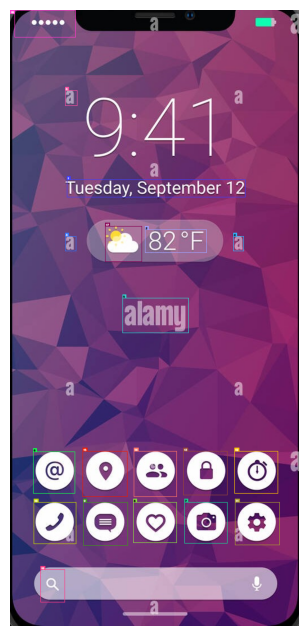

In [5]:
image = Image.open('ui_cropped.jpg')

parsed_image, parsed_content_list = process(image)
display_image(parsed_image)

In [6]:
parsed_content_list[1]

{'type': 'text',
 'bbox': [0.1964980512857437,
  0.2750455439090729,
  0.8132295608520508,
  0.30327868461608887],
 'interactivity': False,
 'content': 'Tuesday,September 12',
 'source': 'box_ocr_content_ocr'}

battery
{
    "primary_focus": {
        "element_id": "hotspot_battery",
        "position": [
            0.925,
            0.025
        ],
        "candidate_type": "platform_hotspot",
        "score": 0.8475846413286567,
        "component_scores": {
            "position": 0.8229616033216415,
            "task": 1.2960000000000003,
            "visual": 0.0
        },
        "scores": 0.8475846413286567,
        "reasoning": "Strong platform convention for android, Highly relevant position for task, Task-relevant hotspot, Tech-savvy user preference"
    },
    "secondary_focuses": [
        {
            "element_id": "hotspot_status_bar",
            "position": [
                0.5,
                0.025
            ],
            "candidate_type": "platform_hotspot",
            "score": 0.3714377346485916,
            "component_scores": {
                "position": 0.9285943366214789,
                "task": 0.0,
                "visual": 0.0
            },
            "

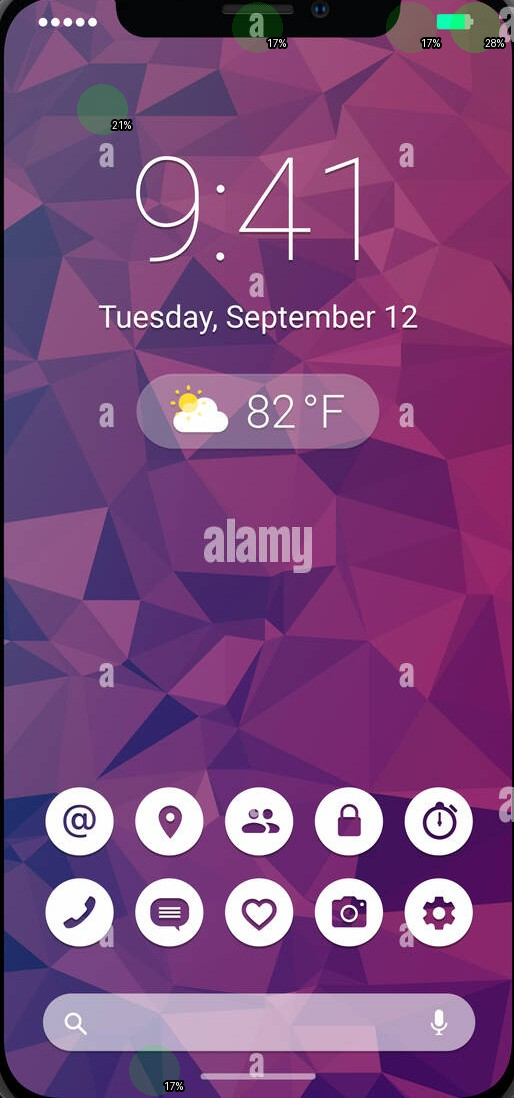

In [13]:
from ui_attention_predictor import UIAttentionPredictor, Platform
import json

# Initialize predictor
attention_predictor = UIAttentionPredictor(
    platform=Platform.ANDROID,
    tech_savviness=8
)

elements_data = [
    # {
    #     "type": "button",
    #     "text": "Settings",
    #     "bounds": {
    #         "x1": 0.1,  # These are normalized coordinates (0-1)
    #         "y1": 0.1,
    #         "x2": 0.2,
    #         "y2": 0.2
    #     }
    # },
    # {
    #     "type": "icon",
    #     "text": "menu",
    #     "bounds": {
    #         "x1": 0.8,
    #         "y1": 0.1,
    #         "x2": 0.9,
    #         "y2": 0.2
    #     }
    # }
    {
        "type": item["type"],
        "text": item["content"],
        "bounds": {
            "x1": min(item["bbox"][0], item["bbox"][2]),
            "x2": max(item["bbox"][0], item["bbox"][2]),
            "y1": min(item["bbox"][1], item["bbox"][3]),
            "y2": max(item["bbox"][1], item["bbox"][3])
        }
    }
    for item in parsed_content_list
]

task_description = "Find the battery icon"
image = Image.open("ui_cropped.jpg")

# Get prediction
result = attention_predictor.predict_attention(
    ui_image=image,
    task=task_description,
    elements_data=elements_data
)

print(json.dumps(result, indent=4))
attention_predictor.visualize_attention(result, Image.open("ui_cropped.jpg"), alpha=0.9)

### Decision making

In [16]:
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from IPython.display import display
from ui_tars import query_ui_tars

confidence_threshold = 0.25

# Load the model
embed_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
cos = nn.CosineSimilarity(dim=0, eps=1e-8)

def caption_single_image(cropped_image, model, processor, prompt=None):
    if not prompt:
        if 'florence' in model.config.name_or_path:
            prompt = "<CAPTION>"
        else:
            prompt = "The image shows"
            
    device = model.device
    if model.device.type == 'cuda':
        inputs = processor(images=cropped_image, text=prompt, return_tensors="pt", do_resize=False).to(device=device, dtype=torch.float16)
    else:
        inputs = processor(images=cropped_image, text=prompt, return_tensors="pt").to(device=device)
    if 'florence' in model.config.name_or_path:
        generated_ids = model.generate(input_ids=inputs["input_ids"],pixel_values=inputs["pixel_values"],max_new_tokens=20,num_beams=1, do_sample=False)
    else:
        generated_ids = model.generate(**inputs, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True, num_return_sequences=1)
    generated_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    
    return generated_text.strip()

def evaluate_cropped_icon(cropped_icon, task_description, threshold=0.7):
    prompt = "Describe this image in one sentence."
    caption = query_ui_tars(prompt, cropped_icon)
    
    embeddings = embed_model.encode([caption, task_description], convert_to_tensor=True)
    print(f"caption: {caption}, task_description: {task_description}")
    similarity = cos(embeddings[0], embeddings[1])
    print(f"similarity: {similarity.item()}")
    return similarity.item() > threshold

def draw_attention(attention_point, ui_image, alpha=0.9) -> Image:
    from PIL import Image, ImageDraw
        
    # Convert to RGBA if not already
    ui_image = ui_image.convert('RGBA')
    
    # Create a transparent overlay for the heatmap
    overlay = Image.new('RGBA', ui_image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    
    # Get image dimensions for coordinate conversion
    width, height = ui_image.size
    
    # Function to convert normalized coordinates to pixel coordinates
    # Flip y-coordinate since PIL uses top-left origin
    def norm_to_pixel(x: float, y: float):
        return (int(x * width), int(y * height))  # Flip y coordinate
    
    x, y = attention_point["position"]
    
    # Convert to pixel coordinates (y is now flipped)
    px, py = norm_to_pixel(x, y)
    
    # Calculate radius based on image size (e.g., 10% of width)
    radius = int(width * 0.1)
    
    # Color intensity based only on confidence
    intensity = int(255 * alpha)
    
    # Choose color based on whether it's a hotspot or UI element
    color = (0, 255, 0, intensity) if attention_point["candidate_type"] == "platform_hotspot" else (255, 0, 0, intensity)  # Green for hotspots, Red for UI elements
    
    # Single solid circle for each attention point
    draw.ellipse(
        [(px - radius, py - radius), (px + radius, py + radius)],
        fill=color,
        outline=None
    )
    
    # Add this line to blend the overlay with the original image
    ui_image = Image.alpha_composite(ui_image, overlay)
    display(ui_image)

def create_spatial_grid(elements):
    # Sort elements by y-coordinate first (rows)
    sorted_by_y = sorted(elements, key=lambda x: x["position"][1])
    
    # Group elements into rows based on y-coordinate proximity
    rows = []
    current_row = []
    y_threshold = 20  # Adjust based on your UI layout
    
    for element in sorted_by_y:
        if not current_row or abs(element["position"][1] - current_row[0]["position"][1]) < y_threshold:
            current_row.append(element)
        else:
            current_row.sort(key=lambda x: x["position"][0])
            rows.append(current_row)
            current_row = [element]
    
    if current_row:
        current_row.sort(key=lambda x: x["position"][0])
        rows.append(current_row)
    
    return rows

def z_scan_pattern(elements_ref, last_element):
    if not last_element:
        # Start from top-left
        return min(elements_ref, key=lambda x: (x["position"][1], x["position"][0]))
    
    spatial_grid = create_spatial_grid(elements_ref)
    current_row_idx = None
    current_col_idx = None
    
    # Find current position in grid
    for i, row in enumerate(spatial_grid):
        for j, element in enumerate(row):
            if element["element_id"] == last_element["element_id"]:
                current_row_idx = i
                current_col_idx = j
                break
        if current_row_idx is not None:
            break
    
    if current_row_idx is None:
        return None
    
    # Z-pattern movement
    if current_row_idx % 2 == 0:  # Moving right
        if current_col_idx < len(spatial_grid[current_row_idx]) - 1:
            return spatial_grid[current_row_idx][current_col_idx + 1]
        elif current_row_idx < len(spatial_grid) - 1:
            # Move to next row, starting from left
            return spatial_grid[current_row_idx + 1][0]
    else:  # Moving left
        if current_col_idx > 0:
            return spatial_grid[current_row_idx][current_col_idx - 1]
        elif current_row_idx < len(spatial_grid) - 1:
            # Move to next row, starting from right
            return spatial_grid[current_row_idx + 1][-1]
    
    return None

def f_scan_pattern(elements_ref, last_element):
    if not last_element:
        # Start from top-left
        return min(elements_ref, key=lambda x: (x["position"][1], x["position"][0]))
    
    spatial_grid = create_spatial_grid(elements_ref)
    current_row_idx = None
    current_col_idx = None
    
    # Find current position in grid
    for i, row in enumerate(spatial_grid):
        for j, element in enumerate(row):
            if element["element_id"] == last_element["element_id"]:
                current_row_idx = i
                current_col_idx = j
                break
        if current_row_idx is not None:
            break
    
    if current_row_idx is None:
        return None
    
    # F-pattern movement
    if current_row_idx == 0:  # First row (top horizontal)
        if current_col_idx < len(spatial_grid[0]) - 1:
            return spatial_grid[0][current_col_idx + 1]
        else:
            # Move to leftmost element of second row
            return spatial_grid[1][0] if len(spatial_grid) > 1 else None
    elif current_col_idx == 0:  # Left vertical line
        if current_row_idx < len(spatial_grid) - 1:
            return spatial_grid[current_row_idx + 1][0]
        else:
            # Move to second element of middle row
            middle_row = len(spatial_grid) // 2
            if len(spatial_grid[middle_row]) > 1:
                return spatial_grid[middle_row][1]
    elif current_row_idx == len(spatial_grid) // 2:  # Middle horizontal
        if current_col_idx < len(spatial_grid[current_row_idx]) - 1:
            return spatial_grid[current_row_idx][current_col_idx + 1]
    
    return None

def layered_scan_pattern(elements_ref, last_element):
    if not last_element:
        # Start from top-left
        return min(elements_ref, key=lambda x: (x["position"][1], x["position"][0]))
    
    spatial_grid = create_spatial_grid(elements_ref)
    current_row_idx = None
    current_col_idx = None
    
    # Find current position in grid
    for i, row in enumerate(spatial_grid):
        for j, element in enumerate(row):
            if element["element_id"] == last_element["element_id"]:
                current_row_idx = i
                current_col_idx = j
                break
        if current_row_idx is not None:
            break
    
    if current_row_idx is None:
        return None
    
    # Layered scanning movement
    if current_row_idx % 2 == 0:  # Moving right in even rows
        if current_col_idx < len(spatial_grid[current_row_idx]) - 1:
            return spatial_grid[current_row_idx][current_col_idx + 1]
        elif current_row_idx < len(spatial_grid) - 1:
            # Move to next row, starting from left
            return spatial_grid[current_row_idx + 1][0]
    else:  # Moving left in odd rows
        if current_col_idx > 0:
            return spatial_grid[current_row_idx][current_col_idx - 1]
        elif current_row_idx < len(spatial_grid) - 1:
            # Move to next row, starting from right
            return spatial_grid[current_row_idx + 1][-1]
    
    return None

def find_next_element_scan(elements_ref, pattern, last_element):
    if pattern == "Spotted Pattern":
        visual_elements = sorted(elements_ref, key=lambda x: x["scores"], reverse=True)
        for i, element in enumerate(visual_elements):
            if element["element_id"] == last_element["element_id"]:
                return visual_elements[i+1]
    elif pattern == "Z-Pattern":
        return z_scan_pattern(elements_ref, last_element)
    elif pattern == "F-Pattern":
        return f_scan_pattern(elements_ref, last_element)
    elif pattern == "Layered Pattern":
        return layered_scan_pattern(elements_ref, last_element)
    
    return None
        

guessing next element..
element: {
    "element_id": "hotspot_battery",
    "position": [
        0.925,
        0.025
    ],
    "candidate_type": "platform_hotspot",
    "score": 0.8475846413286567,
    "component_scores": {
        "position": 0.8229616033216415,
        "task": 1.2960000000000003,
        "visual": 0.0
    },
    "scores": 0.8475846413286567,
    "reasoning": "Strong platform convention for android, Highly relevant position for task, Task-relevant hotspot, Tech-savvy user preference"
}


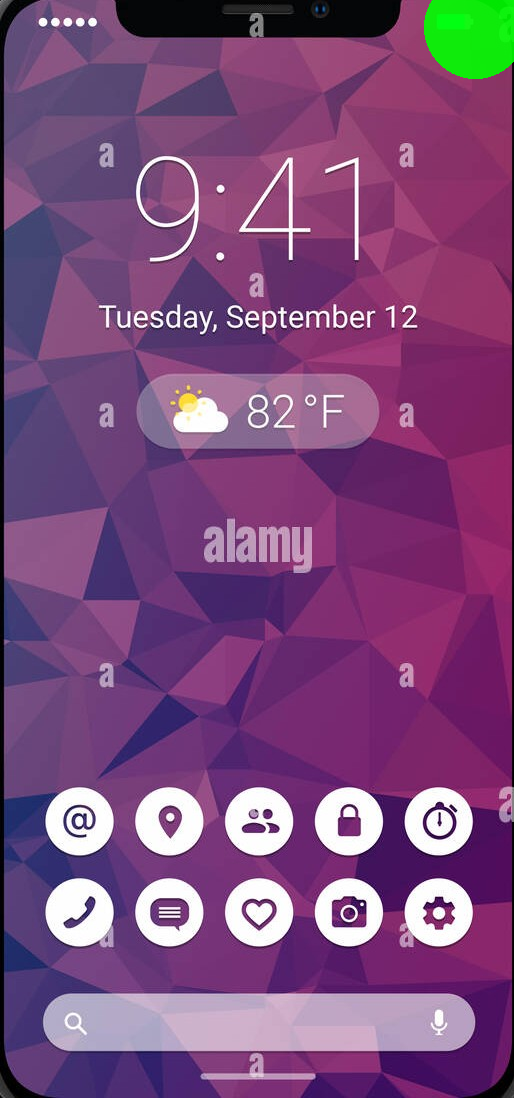

caption: Video-related status or settings., task_description: Find the battery icon
similarity: 0.18708419799804688
reference_sim: 1.0
task completed, element found..


In [17]:
import json

age = 27

pattern = eye_pattern_predictor.predict(age)
elements_ref = result["attention_distribution"].copy()
elements = elements_ref.copy()
last_element = None
scan = False

while elements:
    curr_window = elements[:5]
    
    scores = np.array([point["scores"] for point in curr_window])
    exp_scores = np.exp(scores - np.max(scores))  # Softmax and ubtract max for numerical stability
    confidences = exp_scores / exp_scores.sum()    
    
    if scan:
        print(f"scanning {pattern}..")
        element = find_next_element_scan(elements_ref, pattern, last_element)
    else:
        if confidences[0] < confidence_threshold:
            # means the user is not confident about the icon, use scanning pattern to find the icon
            elements_ref = [point for point in elements if point["candidate_type"] != "platform_hotspot"]
            elements = elements_ref.copy()
            scan = True
            print(f"not confident, switching to scanning pattern: {pattern}")
            continue
        
        print("guessing next element..")
        element = elements[0]
        if not element:
            print("no element found..")
            break
    
    assert element is not None
    print(f"element: {json.dumps(element, indent=4)}")
    
    draw_attention(element, image, alpha=0.9)
    
    image_width, image_height = image.size
    x, y = element["position"]
    
    # Convert normalized coordinates to pixel coordinates
    pixel_x = int(x * image_width)
    pixel_y = int(y * image_height)
    
    # Calculate bounding box size (15% of image width)
    box_size = int(0.15 * image_width)
    
    # Calculate crop coordinates (ensuring we stay within image bounds)
    x1 = max(0, pixel_x - box_size // 2)
    y1 = max(0, pixel_y - box_size // 2)
    x2 = min(image_width, pixel_x + box_size // 2)
    y2 = min(image_height, pixel_y + box_size // 2)
    
    # Convert PIL Image to numpy array, crop, and convert back to PIL Image
    image_array = np.array(image)
    cropped_array = image_array[y1:y2, x1:x2, :]  # Include all channels
    cropped_icon = Image.fromarray(cropped_array)
    
    elements.remove(element)
    
    if evaluate_cropped_icon(cropped_icon, task_description):
        print("task completed, element found..")
        break
    
    print("task not completed, element not found..")
    last_element = element